# DKRZ PyNGL example

## - Filled circles instead of grid cells; the size depends on a quality value.

### Description:
    Draw two plots, first plot is a raster contour plot and the second shows
    the data using filled circles which are sized by a quality variable.

### Effects illustrated:
    o  Creating a contour cellFill plot
    o  Using markers
    o  Using dummy data
    o  Create a legend
    o  Create a labelbar
    o  Add text

Author: Karin Meier-Fleischer

Load modules

In [2]:
from __future__ import print_function
import numpy as np
import Ngl,Nio

Global variables

In [3]:
VALUES =  True                      #-- turn on/off value annotation of first plot
GRID   =  True                      #-- turn on/off the data grid lines of second plot

Create dummy data and coordinates

In [4]:
minlat, maxlat =  47.0, 55.0        #-- minimum and maximum latitude of map
minlon, maxlon =   5.0, 16.0        #-- minimum and maximum longitude of map

#-- generate dummy data and coordinates
nlat, nlon = 16, 22
lat = np.linspace(minlat, maxlat, num=nlat)
lon = np.linspace(minlon, maxlon, num=nlon)

#-- generate dummy data with named dimensions
tempmin, tempmax, tempint = -2.0, 2.0, 0.5
temp   = np.random.uniform(tempmin,tempmax,[nlat,nlon])
temp1d = temp.flatten()
ncells = len(temp1d)

#-- generate random dummy quality data
minqual, maxqual = 1, 4

quality   = np.floor(np.random.uniform(minqual,maxqual+0.5,[nlat,nlon])).astype(int)
quality1d = quality.flatten()

Open graphics output (workstation)

In [5]:
wkres = Ngl.Resources()
wkres.wkBackgroundColor = "gray85"      #-- set background color to light gray

wks = Ngl.open_wks('png','plot_quality_per_cell',wkres)

Set color map, levels and and which color indices to be used

In [6]:
#-- set color map
colmap = "BlueDarkRed18"
Ngl.define_colormap(wks,colmap)

#-- contour levels and color indices
cmap    = Ngl.retrieve_colormap(wks)
ncmap   = len(cmap[:,0])
levels  = np.arange(tempmin,tempmax+tempint,tempint)
nlevels = len(levels)
colors  = np.floor(np.linspace(2,ncmap-1,nlevels+1)).astype(int)
ncolors = len(colors)

Set contour plot resources for RasterFill

In [7]:
res                        =  Ngl.Resources()
res.nglDraw                =  False
res.nglFrame               =  False
res.nglMaximize            =  False             #-- don't maximize plot output, yet
  
res.vpXF                   =  0.09              #-- viewport x-position
res.vpYF                   =  0.95              #-- viewport y-position
res.vpWidthF               =  0.8               #-- viewport width
res.vpHeightF              =  0.8               #-- viewport height
  
res.cnFillMode             = "RasterFill"       #-- use raster fill for contours
res.cnFillOn               =  True              #-- filled contour areas
res.cnLinesOn              =  False  
res.cnLineLabelsOn         =  False  
res.cnInfoLabelOn          =  False  
res.cnLevelSelectionMode   = "ExplicitLevels"   #-- set manual data levels
res.cnLevels               =  levels  
res.cnMonoFillColor        =  False  
res.cnFillColors           =  colors  
  
res.lbBoxMinorExtentF      =  0.15              #-- decrease height of labelbar
res.lbOrientation          = "horizontal"       #-- horizontal labelbar
  
res.mpOutlineBoundarySets  = "National"         #-- draw national map outlines
res.mpOceanFillColor       = "gray90"  
res.mpLandFillColor        = "gray75"  
res.mpInlandWaterFillColor = "gray75"  
res.mpDataBaseVersion      = "MediumRes"        #-- alias to Ncarg4_1
res.mpDataSetName          = "Earth..4"         #-- higher map resolution
res.mpGridAndLimbOn        =  False  
  
res.mpLimitMode            = "LatLon"           #-- map limit mode
res.mpMinLatF              =  minlat-1.0
res.mpMaxLatF              =  maxlat+1.0
res.mpMinLonF              =  minlon-1.0
res.mpMaxLonF              =  maxlon+1.0

res.sfXArray               =  lon
res.sfYArray               =  lat

Draw the contour plot and advance the first frame

In [8]:
contour = Ngl.contour_map(wks,temp,res)

Ngl.draw(contour)
Ngl.frame(wks)

Add values to the grid cells, draw the contour plot and advance the second frame

In [9]:
if(VALUES):
   txres               =  Ngl.Resources()
   txres.gsFontColor   = "black"
   txres.txFontHeightF =  0.01
   for j in range(0,nlat):
      for i in range(0,nlon):
         m = i+j
         txid = "txid"+str(m)
         txid = Ngl.add_text(wks, contour,""+str(quality[j,i]),lon[i],lat[j],txres)

#-- draw the second plot
Ngl.draw(contour)
Ngl.frame(wks)

Create the third plot using a map plot and add grid lines of the data region

In [10]:
plot = Ngl.map(wks,res)

#-----------------------------------------------------------------------------------
#-- draw grid lines of data region if set by GRID global variable
#-----------------------------------------------------------------------------------
if(GRID):
   gres             = Ngl.Resources()
   gres.gsLineColor = "black"
   
   for i in range(0,nlat):
      lx  = [minlon,maxlon]
      ly  = [lat[i],lat[i]]
      lid = "lidy"+str(i)
      lid = Ngl.add_polyline(wks,plot,lx,ly,gres) #-- add grid lines to plot
   
   for j in range(0,nlon):
      lx  = [lon[j],lon[j]]
      ly  = [minlat,maxlat]
      lid = "lidx"+str(j)
      lid = Ngl.add_polyline(wks,plot,lx,ly,gres) #-- add grid lines to plot
      
   Ngl.draw(plot)

Now, create the marker size for each cell - marker sizes for quality 1-4

In [11]:
marker_sizes = np.linspace(0.01,0.04,4)
ms_array     = np.ones(ncells,float)            #-- create array for marker sizes depending 
                                                #-- on quality1d
for ll in range(minqual,maxqual+1):
   indsize = np.argwhere(quality1d == ll)
   ms_array[indsize] = marker_sizes[ll-1]

#-- marker resources
plmres                    =  Ngl.Resources()
plmres.gsMarkerIndex      =  16                 #-- filled circles



Now, create the color array for each cell from temp1d

In [12]:
gscolors = np.zeros(ncells,int)

#-- set color for data less than given minimum value
vlow = np.argwhere(temp1d < levels[0])          #-- get the indices of values less levels(0)
gscolors[vlow] = colors[0]                      #-- choose color

#-- set colors for all cells in between tempmin and tempmax
for i in range(1,nlevels):
   vind = np.argwhere(np.logical_and(temp1d >= levels[i-1],temp1d < levels[i]))  #-- get the indices of 'middle' values
   gscolors[vind] = colors[i]                   #-- choose the colors

#-- set color for data greater than given maximum
vhgh = np.argwhere(temp1d > levels[nlevels-1])    #-- get indices of values greater levels(nl)
gscolors[vhgh] = colors[ncolors-1]              #-- choose color

#-- add the marker to the plot
n=0
for ii in range(0,nlat):
   for jj in range(0,nlon):
      k = jj+ii
      plmres.gsMarkerSizeF =  ms_array[n]       #-- marker size
      plmres.gsMarkerColor =  gscolors[n]       #-- marker color
      plm = "plmark"+str(k)
      plm = Ngl.add_polymarker(wks,plot,lon[jj],lat[ii],plmres) #-- add marker to plot
      n = n + 1

Add a labelbar to the plot

In [13]:
vpx  = Ngl.get_float(plot,"vpXF")               #-- retrieve viewport x-position
vpy  = Ngl.get_float(plot,"vpYF")               #-- retrieve viewport y-position
vpw  = Ngl.get_float(plot,"vpWidthF")           #-- retrieve viewport width
vph  = Ngl.get_float(plot,"vpHeightF")          #-- retrieve viewport height

lbx, lby = vpx, vpy-vph-0.07

lbres                       =  Ngl.Resources()
lbres.vpWidthF              =  vpw              #-- width of labelbar
lbres.vpHeightF             =  0.08             #-- height of labelbar
lbres.lbOrientation         = "horizontal"      #-- labelbar orientation
lbres.lbLabelFontHeightF    =  0.014            #-- labelbar label font size
lbres.lbAutoManage          =  False            #-- we control label bar
lbres.lbFillColors          =  colors           #-- box fill colors  
lbres.lbPerimOn             =  False            #-- turn off labelbar perimeter
lbres.lbMonoFillPattern     =  True             #-- turn on solid pattern
lbres.lbLabelAlignment      = "InteriorEdges"   #-- write labels below box edges

#-- create the labelbar
pid = Ngl.labelbar_ndc(wks, ncolors, list(levels.astype('str')), lbx, lby, lbres)

Add a legend to the plot

In [14]:
legres                    =  Ngl.Resources()    #-- legend resources
legres.gsMarkerIndex      =  16                 #-- filled dots
legres.gsMarkerColor      = "gray50"            #-- legend marker color

txres                     =  Ngl.Resources()    #-- text resources
txres.txFontColor         = "black"
txres.txFontHeightF       =  0.01
txres.txFont              =  30

x, y, ik  = 0.94, 0.47, 0

for il in range(minqual,maxqual):
   legres.gsMarkerSizeF = marker_sizes[ik]
   Ngl.polymarker_ndc(wks, x, y, legres)
   Ngl.text_ndc(wks, ""+str(il), x+0.03, y, txres)
   y  = y + 0.05
   ik = ik + 1

txres.txFontHeightF = 0.012

Ngl.text_ndc(wks,"Quality",x,y,txres)           #-- legend title

Add title and center string to the plot

In [15]:
xpos   = (vpw/2)+vpx
title1 = "Draw data values at lat/lon location as circles"
title2 = "the size is defined by the quality variable"

txres.txFont        =  21
txres.txFontHeightF =  0.018

Ngl.text_ndc(wks, title1, xpos, 0.96,  txres)
Ngl.text_ndc(wks, title2, xpos, 0.935, txres)
 
#-----------------------------------------------------------------------------------
#-- add center string
#-----------------------------------------------------------------------------------
y = vpy+0.035                               #-- y-position
txcenter = "Quality: min = "+str(quality.min())+"  max = "+str(quality.max())

txres.txFontHeightF = 0.008                 #-- font size for string
txres.txJust        = "CenterCenter"        #-- text justification

Ngl.text_ndc(wks, txcenter, 0.5, y, txres)  #-- add text to wks

Draw the third plot and advance the frame

In [16]:
Ngl.draw(plot)
Ngl.frame(wks)

Show the plots in this notebook

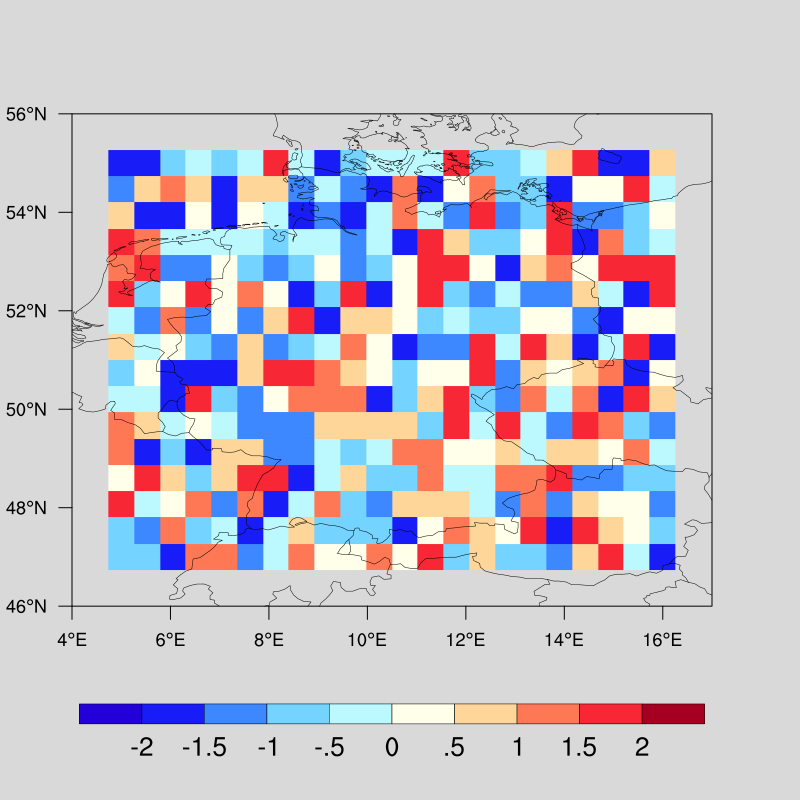

In [17]:
from IPython.display import Image
Image(filename='plot_quality_per_cell.000001.png')

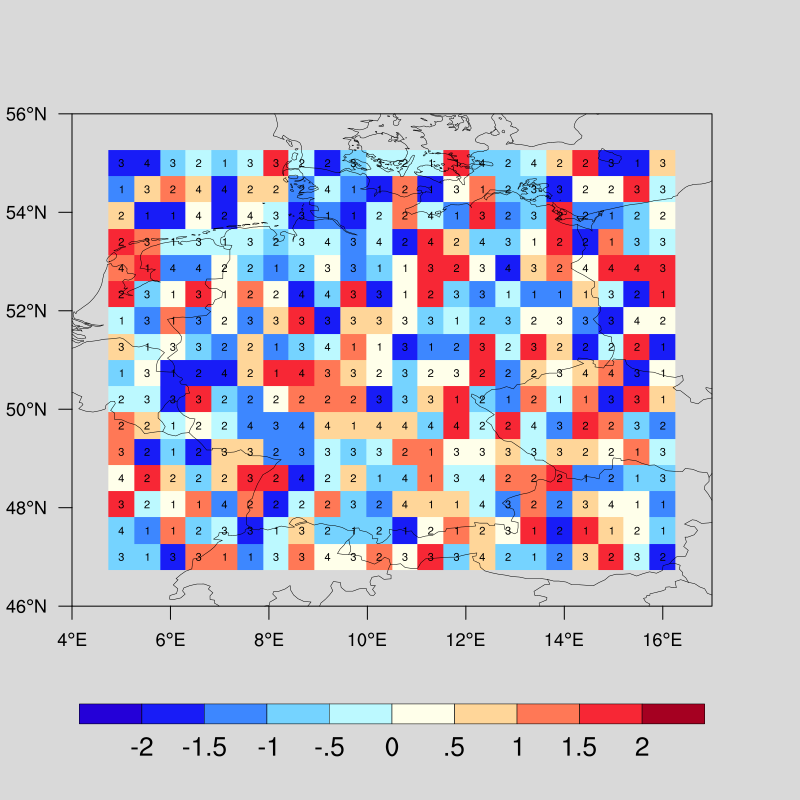

In [18]:
Image(filename='plot_quality_per_cell.000002.png')

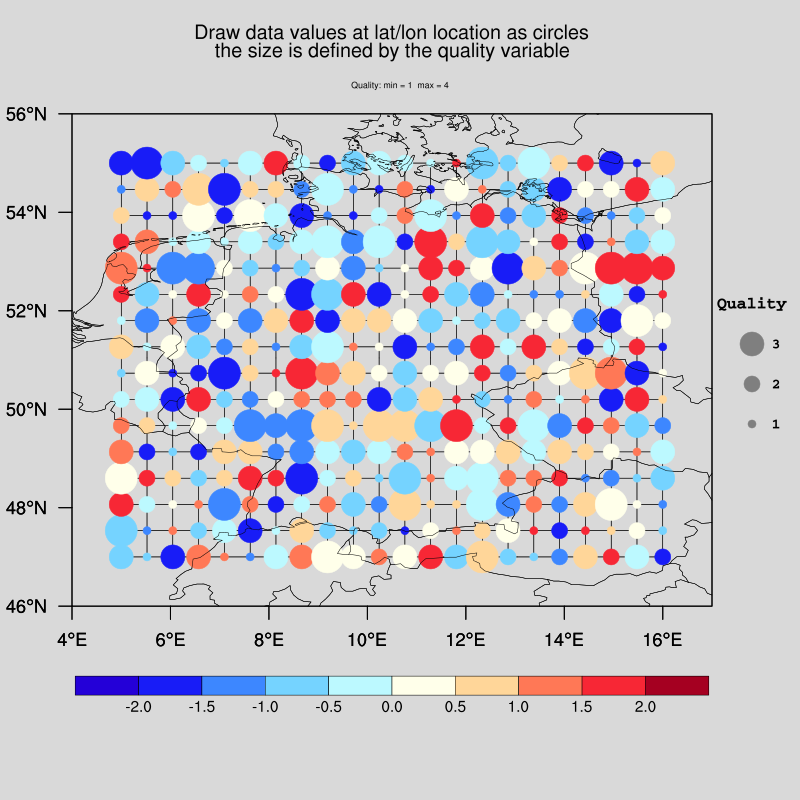

In [19]:
Image(filename='plot_quality_per_cell.000003.png')